In [1]:
import torch # Core functionality
import torch.nn as nn # Component for building neural networks
import torch.optim as optim # Tools for training those networks

# Ensures that all of the results that we create are consistent every time
torch.manual_seed(45)

In [2]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time



def plot_data(distances, times, normalize=False):
    """
    Creates a scatter plot of the data points.

    Args:
        distances: The input data points for the x-axis.
        times: The target data points for the y-axis.
        normalize: A boolean flag indicating whether the data is normalized.
    """
    # Create a new figure with a specified size
    plt.figure(figsize=(8, 6))

    # Plot the data points as a scatter plot
    plt.plot(distances.numpy(), times.numpy(), color='orange', marker='o', linestyle='none', label='Actual Delivery Times')

    # Check if the data is normalized to set appropriate labels and title
    if normalize:
        # Set the plot title for normalized data
        plt.title('Normalized Delivery Data (Bikes & Cars)')
        # Set the x-axis label for normalized data
        plt.xlabel('Normalized Distance')
        # Set the y-axis label for normalized data
        plt.ylabel('Normalized Time')
        # Display the legend
        plt.legend()
        # Add a grid to the plot
        plt.grid(True)
        # Show the plot
        plt.show()

    # Handle the case for un-normalized data
    else:
        # Set the plot title for un-normalized data
        plt.title('Delivery Data (Bikes & Cars)')
        # Set the x-axis label for un-normalized data
        plt.xlabel('Distance (miles)')
        # Set the y-axis label for un-normalized data
        plt.ylabel('Time (minutes)')
        # Display the legend
        plt.legend()
        # Add a grid to the plot
        plt.grid(True)
        # Show the plot
        plt.show()
    
    

def plot_final_fit(model, distances, times, distances_norm, times_std, times_mean):
    """
    Plots the predictions of a trained model against the original data,
    after de-normalizing the predictions.

    Args:
        model: The trained model used for prediction.
        distances: The original, un-normalized input data.
        times: The original, un-normalized target data.
        distances_norm: The normalized input data for the model.
        times_std: The standard deviation used for de-normalization.
        times_mean: The mean value used for de-normalization.
    """
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculations for prediction
    with torch.no_grad():
        # Get predictions from the model using normalized data
        predicted_norm = model(distances_norm)

    # De-normalize the predictions to their original scale
    predicted_times = (predicted_norm * times_std) + times_mean

    # Create a new figure for the plot
    plt.figure(figsize=(8, 6))

    # Plot the original data points
    plt.plot(distances.numpy(), times.numpy(), color='orange', marker='o', linestyle='none', label='Actual Data (Bikes & Cars)')

    # Plot the de-normalized predictions from the model
    plt.plot(distances.numpy(), predicted_times.numpy(), color='green', label='Non-Linear Model Predictions')

    # Set the title of the plot
    plt.title('Non-Linear Model Fit vs. Actual Data')
    # Set the x-axis label
    plt.xlabel('Distance (miles)')
    # Set the y-axis label
    plt.ylabel('Time (minutes)')
    # Add a legend to the plot
    plt.legend()
    # Enable the grid
    plt.grid(True)
    # Display the plot
    plt.show()

    

def plot_training_progress(epoch, loss, model, distances_norm, times_norm):
    """
    Plots the training progress of a model on normalized data,
    showing the current fit at each epoch.

    Args:
        epoch: The current training epoch number.
        loss: The loss value at the current epoch.
        model: The model being trained.
        distances_norm: The normalized input data.
        times_norm: The normalized target data.
    """
    # Clear the previous plot from the output cell
    clear_output(wait=True)

    # Make predictions using the current state of the model
    predicted_norm = model(distances_norm)

    # Convert tensors to NumPy arrays for plotting
    x_plot = distances_norm.numpy()
    y_plot = times_norm.numpy()
    
    # Detach predictions from the computation graph and convert to NumPy
    y_pred_plot = predicted_norm.detach().numpy()

    # Sort the data based on distance to ensure a smooth line plot
    sorted_indices = x_plot.argsort(axis=0).flatten()

    # Create a new figure for the plot
    plt.figure(figsize=(8, 6))

    # Plot the original normalized data points
    plt.plot(x_plot, y_plot, color='orange', marker='o', linestyle='none', label='Actual Normalized Data')

    # Plot the model's predictions as a line
    plt.plot(x_plot[sorted_indices], y_pred_plot[sorted_indices], color='green', label='Model Predictions')

    # Set the title of the plot, including the current epoch
    plt.title(f'Epoch: {epoch + 1} | Normalized Training Progress')
    # Set the x-axis label
    plt.xlabel('Normalized Distance')
    # Set the y-axis label
    plt.ylabel('Normalized Time')
    # Display the legend
    plt.legend()
    # Add a grid to the plot
    plt.grid(True)
    # Show the plot
    plt.show()

    # Pause briefly to allow the plot to be rendered
    time.sleep(0.05)

In [3]:
# Combined dataset: bikes for short distances, cars for longer ones
distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# Corresponding delivery times in minutes
times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

In [4]:
# Calculate the mean and standard deviation for the 'distances' tensor
distances_mean = distances.mean()
distances_standard_deviation = distances.std()

# Calculate the mean and standard deviation for the 'times' tensor
times_mean = times.mean()
times_standard_deviation = times.std()

# Apply standardization to the distances
distances_norm = (distances - distances_mean) / distances_standard_deviation

# Apply standardization to the times
times_norm = (times - times_mean) / times_standard_deviation

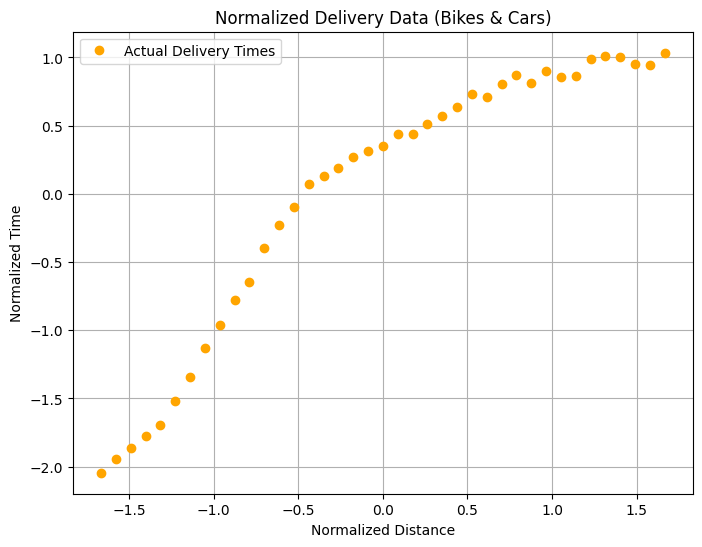

In [5]:
plot_data(distances_norm, times_norm, normalize=True)

In [6]:
# Generating the model
model = nn.Sequential(
    nn.Linear(1, 3),
    nn.ReLU(),
    nn.Linear(3,1)
)

In [7]:
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

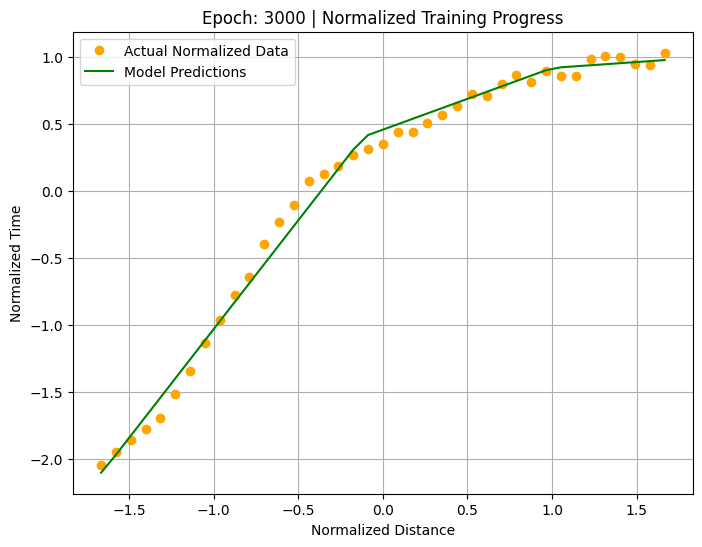


Training Complete.

Final Loss: 0.006756513379514217


In [8]:
# Training loop
for epoch in range(3000):
    optimizer.zero_grad()
    # Make predictions (forward passing)
    outputs = model(distances_norm)
    # Calculate the loss
    loss = loss_function(outputs, times_norm)
    # Backwards pass
    loss.backward()
    # Update the parameters
    optimizer.step()

    # Creating a live plot
    if (epoch + 1) % 50 == 0:
        plot_training_progress(
            epoch=epoch,
            loss=loss,
            model=model,
            distances_norm=distances_norm,
            times_norm=times_norm
        )

print("\nTraining Complete.")
print(f"\nFinal Loss: {loss.item()}")

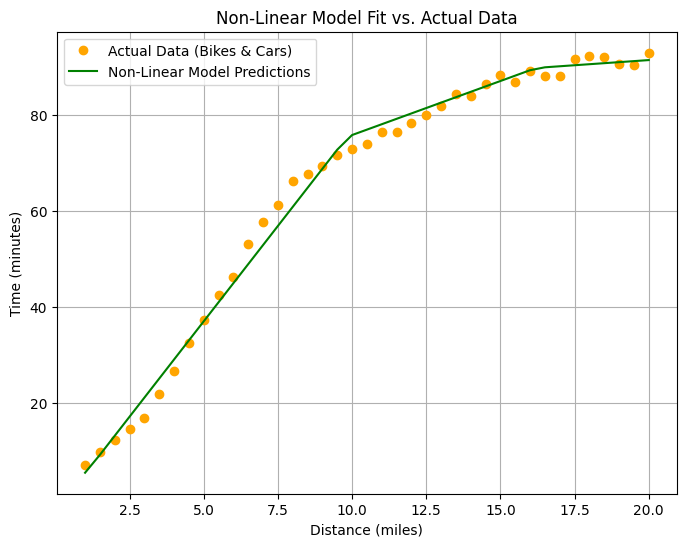

In [9]:
plot_final_fit(model, distances, times, distances_norm, times_standard_deviation, times_mean)

In [10]:
distance_to_predict = 30.0

In [11]:
with torch.no_grad():
    distance_tensor = torch.tensor([[distance_to_predict]], dtype=torch.float32)
    new_distance_norm = (distance_tensor - distances_mean) / distances_standard_deviation

    predicated_time_norm = model(new_distance_norm)

    predicted_time_actual = (predicated_time_norm * times_standard_deviation) + times_mean

    print(f"Prediction for a {distance_to_predict}-mile delivery: {predicted_time_actual.item():.1f} minutes")

    if predicted_time_actual.item() > 45:
        print("\nDecision: Do NOT promise the delivery in under 45 minutes")
    else:
        if distance_to_predict <= 3:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (<= 3 miles), use a bike.")
        else:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles ( > 3 miles), use a car.")

Prediction for a 30.0-mile delivery: 95.7 minutes

Decision: Do NOT promise the delivery in under 45 minutes
